In [1]:
%cd python

C:\Users\kisha\Documents\LRP_Demo\python


# Notebook to play around the different threshold, digits and methods

In [2]:
import matplotlib.pyplot as plt
import time
import numpy
import numpy as np
import importlib.util as imp
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis

import model_io
import data_io
import render
# import cv2
import modules

In [3]:
def convertPixels_to_XY(pixels, dim=2):
    cord = []
    for pixel in pixels:
        y = pixel%32
        x = int(pixel/32)
        for i in range(3):
            for j in range(3):
                cord.append((3*x+i, 3*y+j))
    return cord

In [4]:
#load a neural network, as well as the MNIST test data and some labels
nn = model_io.read('../models/Emnist_cnn', fmt="pickled")
nn.drop_softmax_output_layer() #drop softnax output layer for analyses

loading pickled model from ../models/Emnist_cnn
removing softmax output mapping


In [9]:
X = data_io.read('../data/EMNIST/Emnist_test_images.npy')
Y = data_io.read('../data/EMNIST/Emnist_test_labels.npy')
X = np.array([x.T for x in X])

loading np-formatted data from ../data/EMNIST/Emnist_test_images.npy
loading np-formatted data from ../data/EMNIST/Emnist_test_labels.npy


In [10]:
# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

In [11]:
#reshape the vector representations in X to match the requirements of the CNN input
X = np.reshape(X,[X.shape[0],28,28,1])
X = np.pad(X,((0,0),(2,2),(2,2),(0,0)), 'constant', constant_values = (-1.,))

In [12]:
# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y.astype(int) - 1
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

In [14]:
acc = np.mean(np.argmax(nn.forward(X), axis=1) == np.argmax(Y, axis=1))
if not np == numpy: # np=cupy
    acc = np.asnumpy(acc)
print('Target model test accuracy is: {:0.4f}'.format(acc))

Target model test accuracy is: 0.9133


In [15]:
#permute data order for demonstration. or not. your choice.
I = np.arange(X.shape[0])
#I = np.random.permutation(I)

In [25]:
#Select a Digit between 5-9
clas = 13
for i in I:
  if np.argmax(Y[i]) == clas:
    break


In [28]:
#Find Relevance using Base network

x = X[na,i,:]

#forward pass and prediction
ypred = nn.forward(x)
print('True label:     ', np.argmax(Y[i]))
print('Predicted label:', np.argmax(ypred),'\n')
print('Prediction Score 0-4', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

R_base = []
#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
lrp_type = ["simple", "alphabeta", "epsilon", "ww"]
lrp_t = [1, 4, 0.01, 1]
for k in range(len(lrp_type)):
    R_base.append(nn.lrp(Rinit, lrp_type[k], lrp_t[k]))
    
    


#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)
    for k in range(len(lrp_type)):
        R_base[k] = np.asnumpy(R_base[k])

# print(len(R[0]))
#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_base = []
for k in range(len(lrp_type)):
    hm_base.append(render.hm_to_rgb(R_base[k], X = x, scaling = 3, sigma = 2))
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# # display the image as written to file
# plt.imshow(hm_base, interpolation = 'none')
# plt.axis('off')
# plt.show()

True label:      0
Predicted label: 16 

Prediction Score 0-4 [[15.40569105  1.48021922  1.09502527  8.15515517 -4.86575833 -7.02245186
  12.51570834  1.79601592 -1.89220682 -2.0831071  -6.93320777 -1.21819345
  -5.68363456  0.80650051  4.97601011 -1.01230576 16.08225525 -2.70474437
  -1.08167309 -7.78210952  7.98310151 -1.5984444   0.31782527 -5.95660176
  -1.4313926  -1.45406907]]


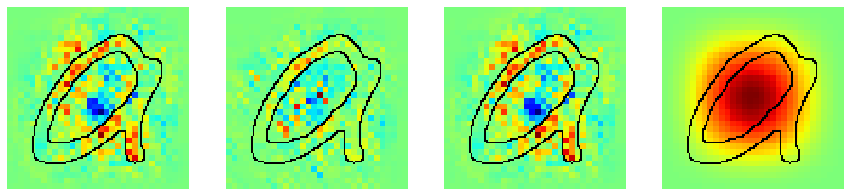

In [29]:

fig, grid = plt.subplots(1, 4, figsize=(15,40)) 


for i in range(4):
    image = hm_base[i]
        
            
    grid[i].imshow(image)
    grid[i].axis('off')
#     print("-------------------------------------------------")
